In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd, numpy as np
import feather, h5py
import matplotlib.pyplot as plt
import seaborn as sns
import ipympl


# Merge the outputs of the optimization model with the power plant characteristics

In [3]:
#gen = feather.read_dataframe('/home/gchossie/epa_ace/outputs/gen_orig_alan_v2.feather')
#gen = feather.read_dataframe('./outputs/eia_2030_regional_floats/gen_no-nuclear_EIA_2030_renewables.feather')
base_name = 'base'
gen = feather.read_dataframe(f'./outputs/gen_{base_name}.feather')

case_name = 'amtk_current'
gen_case = feather.read_dataframe(f'./outputs/gen_{case_name}.feather')

In [4]:
#read in the characteristics
carac = pd.read_csv(f'./inputs/inputs_gen_{base_name}.csv')
carac_case = pd.read_csv(f'./inputs/inputs_gen_{case_name}.csv')

#assign a generation column based on the gen df
carac['generation'] = gen.sum(axis=1)
carac_case['generation'] = gen_case.sum(axis=1)
#calculate capacity factor
carac['capafac'] = carac['generation'] / (8759 * carac['Capacity'])
carac_case['capafac'] = carac_case['generation'] / (8759 * carac_case['Capacity'])

In [5]:
print(carac_case['generation'].sum()/1000/1000,'TWh')

4078.4172075548695 TWh


### Check the capacity factors

In [6]:
carac.loc[carac['capafac'] > 1.01, :]

,Unnamed: 0,RegionName,FuelType,FuelCostTotal,PLCO2RTA,ORISCode,DIVISIONCE,UNITID,Capacity,OBJECTID,...,PLN2ORTA,PLCH4RTA,PRMVR,FUELU1,pm.mmbtu,pm.mwh,generationCO2,g,generation,capafac
10,10,ERC_REST,Biomass,40.400000,17.333942,54338,WSC-TX,GEND,12.0,16883.0,...,0.024040,0.182343,ST,OBS,0.000000,0.000000,42.0,3801.0,1.023687e+06,9.739384
11,11,ERC_REST,Coal,23.273161,1135.165674,6181,WSC-TX,2,436.0,3370.0,...,0.017690,0.122923,ST,SUB,0.000021,0.210118,2285.0,2622.0,8.198424e+06,2.146789
15,15,ERC_REST,Coal,20.960491,1107.218179,6136,WSC-TX,1,466.0,14025.0,...,0.017236,0.117933,ST,SUB,0.000021,0.207789,2140.0,2589.0,5.229123e+06,1.281116
18,18,ERC_REST,Coal,32.443070,1289.261990,6183,WSC-TX,SM-1,391.0,3372.0,...,0.020412,0.140613,ST,LIG,0.000049,0.579246,2649.0,2624.0,5.167810e+06,1.508951
22,22,ERC_REST,Coal,17.553862,1074.947973,6179,WSC-TX,3,444.0,14045.0,...,0.016783,0.116573,ST,SUB,0.000021,0.215109,2339.0,2619.0,5.007913e+06,1.287714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16879,16879,SPP_WEST,Coal,22.830000,1228.196983,165,NaN,NaN,1734.0,NaN,...,0.019504,0.047627,NaN,RC,NaN,NaN,NaN,NaN,2.389280e+07,1.573126
16883,16883,S_VACA,Coal,22.830000,810.225591,7210,NaN,NaN,417.0,NaN,...,0.014968,0.009979,NaN,RC,NaN,NaN,NaN,NaN,2.065111e+07,5.653960
16885,16885,S_VACA,Coal,22.830000,837.146158,3298,NaN,NaN,714.0,NaN,...,0.015422,0.010433,NaN,RC,NaN,NaN,NaN,NaN,1.055623e+07,1.687937
16886,16886,S_VACA,Coal,22.830000,1107.664966,6249,NaN,NaN,1260.0,NaN,...,0.017690,0.014061,NaN,RC,NaN,NaN,NaN,NaN,1.604880e+07,1.454178


# Import eGrid data

In [7]:
egrid = feather.read_dataframe('./inputs/egrid.feather')

In [8]:
# convert us names to abbreviations
us_state_abbrev={'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',\
                'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia':\
                'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho':\
                'ID','Illinois': 'IL','Indiana': 'IN','Iowa':'IA','Kansas': 'KS','Kentucky': 'KY',\
                'Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA',\
                'Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO',\
                'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH',\
                 'New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',\
                 'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK',\
                 'Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',\
                 'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT',\
                 'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia':\
                 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

## Plot generation by state

In [9]:
carac['StateAbb'] = carac['StateName'].apply(lambda x: us_state_abbrev[x])

In [10]:
print(carac.columns)

Index(['Unnamed: 0', 'RegionName', 'FuelType', 'FuelCostTotal', 'PLCO2RTA',
       'ORISCode', 'DIVISIONCE', 'UNITID', 'Capacity', 'OBJECTID', 'UniqueID',
       'StateName', 'CountyName', 'CountyCode', 'HeatRate', 'PlantType',
       'FossilUnit', 'NERC', 'SUBRGN', 'FIPSCNTY', 'LAT', 'LON', 'PLNOXRTA',
       'PLSO2RTA', 'PLN2ORTA', 'PLCH4RTA', 'PRMVR', 'FUELU1', 'pm.mmbtu',
       'pm.mwh', 'generationCO2', 'g', 'generation', 'capafac', 'StateAbb'],
      dtype='object')


In [11]:
print(egrid.columns)

Index(['SEQPLT16', 'PSTATABB', 'PNAME', 'ORISPL', 'OPRNAME', 'OPRCODE',
       'UTLSRVNM', 'UTLSRVID', 'BANAME', 'BACODE',
       ...
       'PLWIPR', 'PLSOPR', 'PLGTPR', 'PLOFPR', 'PLOPPR', 'PLTNPR', 'PLTRPR',
       'PLTHPR', 'PLCYPR', 'PLCNPR'],
      dtype='object', length=120)


In [12]:
#tmp = pd.concat([egrid.groupby('SUBRGN')['PLNGENAN'].sum(), carac.groupby('RegionName')['generation'].sum()], axis=1)
tmp = pd.concat([carac.groupby('RegionName')['generation'].sum()], axis=1)

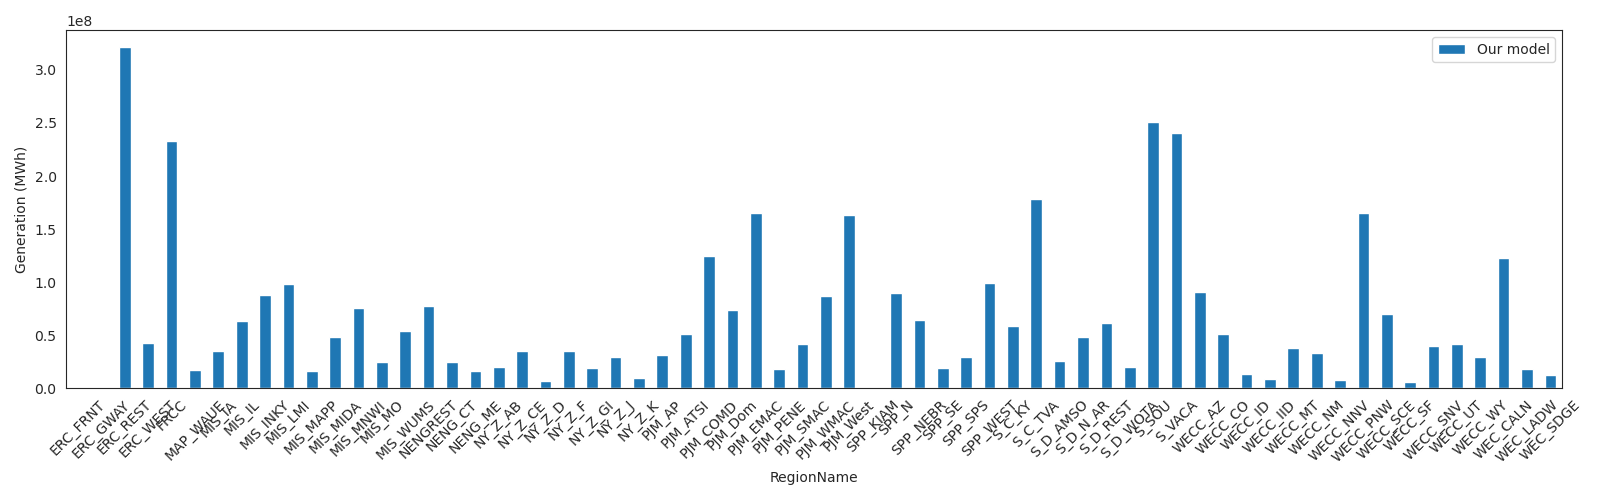

In [13]:
sns.set_style('white')
fig, ax = plt.subplots(1,1, figsize=(16,5))
tmp.rename(columns={'PLNGENAN': 'eGRID', 'generation': 'Our model'}).plot.bar(ax=ax)
ax.set_ylabel('Generation (MWh)')
kw = {'rotation': 45}
ax.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()
#plt.savefig('gen_per_state.png', dpi=300)

## Plot generation by state for base and case

In [14]:
carac['StateAbb'] = carac['StateName'].apply(lambda x: us_state_abbrev[x])
carac_case['StateAbb'] = carac_case['StateName'].apply(lambda x: us_state_abbrev[x])

In [18]:
#tmp = pd.concat([(carac_case.groupby('RegionName')['generation'].sum()-carac.groupby('RegionName')['generation'].sum())/carac.groupby('RegionName')['generation'].sum()*100], axis=1) # %
#tmp = pd.concat([(carac_case.groupby('SUBRGN')['generation'].sum()-carac.groupby('SUBRGN')['generation'].sum())/carac.groupby('SUBRGN')['generation'].sum()*100], axis=1) # %
#tmp = pd.concat([(carac_case.groupby('RegionName')['generation'].sum()-carac.groupby('RegionName')['generation'].sum())], axis=1) # MWh
tmp = pd.concat([(carac_case.groupby('SUBRGN')['generation'].sum()-carac.groupby('SUBRGN')['generation'].sum())], axis=1) # MWh

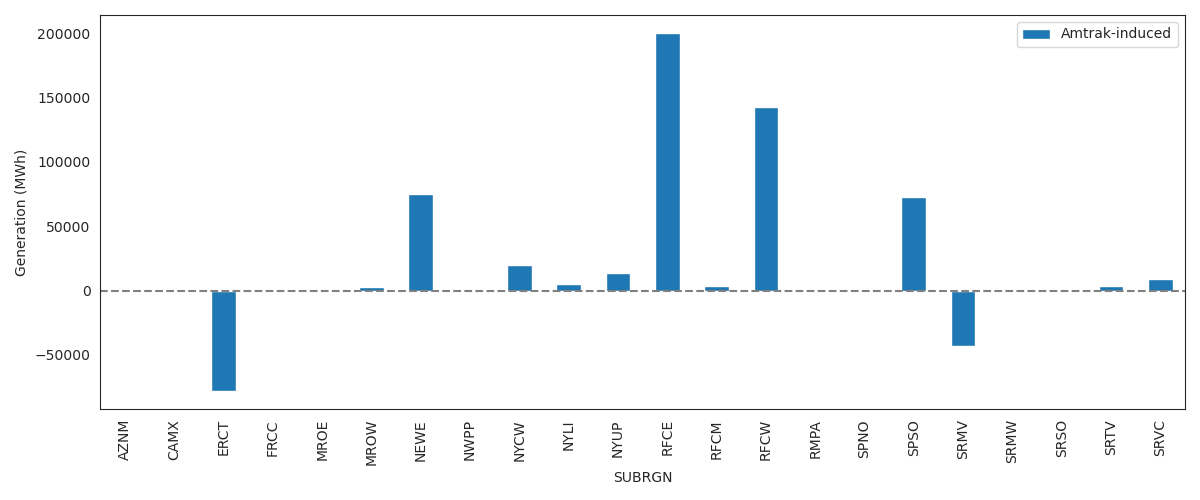

In [19]:
sns.set_style('white')
fig, ax = plt.subplots(1,1, figsize=(12,5))
tmp.rename(columns={'generation': 'Amtrak-induced'}).plot.bar(ax=ax)
#ax.set_ylabel('Change in generation (%)')
ax.set_ylabel('Generation (MWh)')
plt.axhline(y=0, color='grey', linestyle='--') # Add a horizontal line at y=0
kw = {'rotation': 90}
ax.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()
#plt.savefig('gen_per_state.png', dpi=300)

In [16]:
egrid.groupby(['SUBRGN','PLFUELCT'])['PLNGENAN'].sum().loc['SPSO']

PLFUELCT
BIOMASS    2.307505e+06
COAL       6.094964e+07
GAS        6.061905e+07
HYDRO      5.668096e+06
OFSL       1.395410e+05
OIL        1.193003e+03
OTHF       8.512800e+04
SOLAR      1.638370e+05
WIND       2.684675e+07
Name: PLNGENAN, dtype: float64

In [17]:
carac.groupby(['StateAbb', 'FuelType'])['PLNOXRTA'].mean().loc['IN']

FuelType
Coal            1.637710
Hydro                NaN
LF Gas          6.948892
MSW             1.287742
NaturalGas      0.646177
Non-Fossil     19.418037
Oil           121.760392
Solar                NaN
Wind                 NaN
Name: PLNOXRTA, dtype: float64

In [18]:
carac.groupby(['StateAbb', 'FuelType'])['generation'].sum().loc['IN'].sort_values(ascending=False)

FuelType
Coal          8.177083e+07
NaturalGas    1.236753e+07
Wind          5.994603e+06
MSW           1.313850e+06
Solar         5.615323e+05
LF Gas        5.430580e+05
Hydro         1.977432e+05
Non-Fossil    3.503600e+04
Oil           2.649169e+03
Name: generation, dtype: float64

In [19]:
egrid.groupby(['PSTATABB','PLFUELCT'])['PLNOXAN'].mean().loc['IN'] * 907.185

PLFUELCT
BIOMASS    2.179130e+05
COAL       3.755627e+06
GAS        1.091278e+05
HYDRO               NaN
OFSL       1.282329e+05
OIL        1.013326e+03
OTHF       1.355929e+05
SOLAR               NaN
WIND                NaN
Name: PLNOXAN, dtype: float64

## Plot generation by primary fuel type, compare to eGrid

In [20]:
egrid.loc[pd.isnull(egrid['PLFUELCT']), 'PLFUELCT'] = ''

In [21]:
# Translate eGrid fuel cat name to ours
egrid.loc[pd.isnull(egrid['PLFUELCT']), 'PLFUELCT'] = ''
egrid['PLFUELCT'] = egrid['PLFUELCT'].apply(lambda x: x[:1].upper() + x[1:].lower())

In [22]:
#rename gas to natural gas
egrid.loc[egrid['PLFUELCT'] == 'Gas', 'PLFUELCT'] = 'NaturalGas'

In [23]:
# Regroup hydro and pumps
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro'
carac_case.loc[carac_case['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro'

In [24]:
tmp = pd.concat([egrid.groupby('PLFUELCT')['PLNGENAN'].sum(), carac.groupby('FuelType')['generation'].sum()], axis=1)

In [25]:
reg = 'RFCE'
sube = egrid.loc[egrid['SUBRGN'] == reg].groupby('PLFUELCT')['PLNGENAN'].sum()
subc = carac.loc[carac['SUBRGN'] == reg].groupby('FuelType')['generation'].sum()
tmp = pd.DataFrame({'egrid': sube, 'Me': subc})

In [26]:
carac.groupby('FuelType')['generation'].sum().plot.bar()


<Axes: xlabel='FuelType', ylabel='Generation (MWh)'>

In [27]:
## Plot generation by primary fuel type for base and case

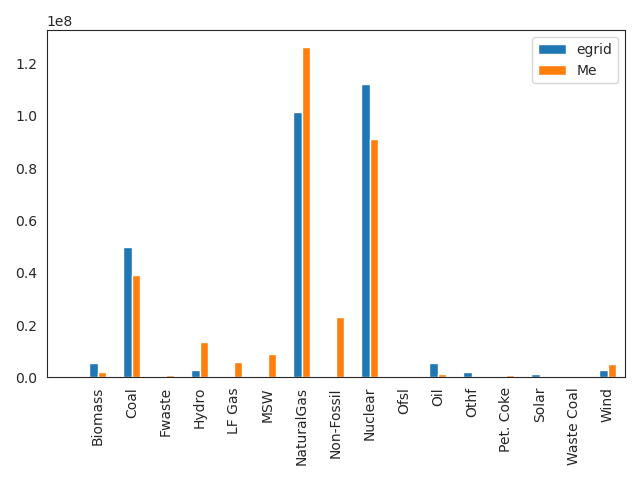

In [28]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()
#plt.show()

## Plot generation by primary fuel type for base and case

In [29]:
tmp = pd.concat([carac.groupby('FuelType')['generation'].sum(), carac_case.groupby('FuelType')['generation'].sum()], axis=1)

In [30]:
reg = 'RFCE'
subc = carac_case.loc[carac_case['SUBRGN'] == reg].groupby('FuelType')['generation'].sum()
subb = carac.loc[carac['SUBRGN'] == reg].groupby('FuelType')['generation'].sum()
#tmp = pd.DataFrame({'case': subc, 'base': subb})
tmp = pd.DataFrame({'% difference': (subc-subb)/subb*100})

In [31]:
carac.groupby('FuelType')['generation'].sum().plot.bar()
carac_case.groupby('FuelType')['generation'].sum().plot.bar()

<Axes: xlabel='FuelType'>

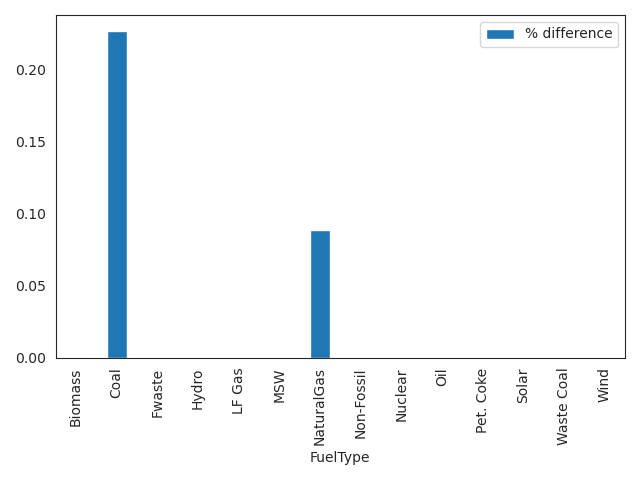

In [32]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()
#plt.show()

In [33]:
tmp = pd.concat([egrid.groupby('PLPRMFL')['PLNGENAN'].sum(), carac.groupby('FUELU1')['generation'].sum()], axis=1)

In [34]:
egrid['PLCO2AN'].sum()*.907

np.float64(1845281822.142205)

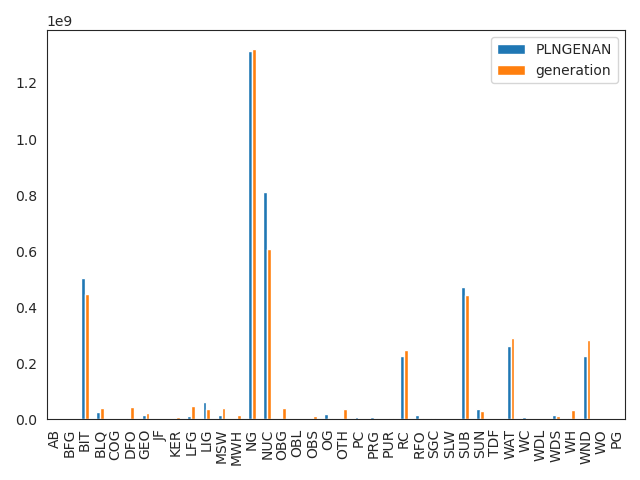

In [35]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()

# Compute emissions

In [36]:
# Import needs emissions
#needs = pd.read_excel('./good_model_inputs/needs_v6_12-18-2019.xlsx', sheet_name='NEEDS v6_active')

In [37]:
#tst = needs[['UniqueID_Final', 'Heat Rate (Btu/kWh)','Mode 2 NOx Rate (lbs/mmBtu)','SO2 Permit Rate (lbs/mmBtu)']]
#mgd = carac.rename(columns={'UniqueID': 'UniqueID_Final'}).merge(tst, on='UniqueID_Final', how='outer')
#mgd['NOX emissions (kg)'] = carac['generation'] * mgd['Heat Rate (Btu/kWh)'] * mgd['Mode 2 NOx Rate (lbs/mmBtu)'] * 1e-3 * 0.45359 # 0.45 kg / lb
#mgd['SO2 emissions (kg)'] = carac['generation'] * mgd['Heat Rate (Btu/kWh)'] * mgd['SO2 Permit Rate (lbs/mmBtu)'] * 1e-3 * 0.45359

In [38]:
# emissions in kg
region_tots = feather.read_dataframe('./inputs/egrid_corr_fac.feather').set_index('index')
carac['NOX corr'] = carac['SUBRGN'].apply(lambda x: region_tots['NOX corr fac'][x])
carac['SO2 corr'] = carac['SUBRGN'].apply(lambda x: region_tots['SO2 corr fac'][x])
carac['NOX emissions (kg)'] = carac['generation'] * carac['PLNOXRTA']# * carac['NOX corr']
carac['SO2 emissions (kg)'] = carac['generation'] * carac['PLSO2RTA'] #* carac['SO2 corr']
carac['N2O emissions (kg)'] = carac['generation'] * carac['PLN2ORTA']
carac['CH4 emissions (kg)'] = carac['generation'] * carac['PLCH4RTA']
carac['CO2 emissions (kg)'] = carac['generation'] * carac['PLCO2RTA']

In [39]:
poll = 'CO2'
df = carac
print((df[f'{poll} emissions (kg)'].sum() - egrid[f'PL{poll}AN'].sum()*907.185) / (egrid[f'PL{poll}AN'].sum()*907.185))
#tmp = pd.concat([egrid.groupby('PLPRMFL')[f'PL{poll}AN'].sum(), carac.groupby('FUELU1')[f'{poll} emissions (kg)'].sum()], axis=1, sort=True)
tmp = pd.concat([egrid.groupby('SUBRGN')[f'PL{poll}AN'].sum(), df.groupby('SUBRGN')[f'{poll} emissions (kg)'].sum()], axis=1, sort=True)
tmp[f'PL{poll}AN'] *= 907.185 #kg / sort ton

0.010820575091907522


In [40]:
tmp

,PLCO2AN,CO2 emissions (kg)
SUBRGN,,
AKGD,2.288562e+09,NaN
AKMS,3.719237e+08,NaN
AZNM,7.873777e+10,5.156161e+10
CAMX,4.803114e+10,5.659354e+10
ERCT,1.784930e+11,1.409940e+11
FRCC,1.052734e+11,9.613169e+10
HIMS,1.432666e+09,NaN
HIOA,5.436155e+09,NaN
MROE,1.549082e+10,2.629202e+09


In [41]:
tmp[f'{poll} emissions (kg)'].sum()

np.float64(1865629285844.187)

In [42]:
tmp[f'{poll} emissions (kg)'].sum()

np.float64(1865629285844.187)

In [43]:
tmp[f'PL{poll}AN'].sum()

np.float64(1845658202668.2207)

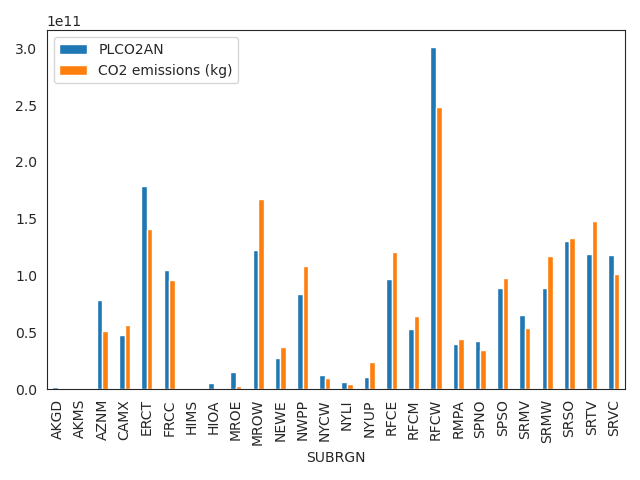

In [44]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()

In [45]:
reg = 'NWPP'
df = carac
sp = 'SO2'
print('Mean :', df.loc[df['SUBRGN'] == reg, f'PL{sp}RTA'].mean(), ' Max :', df.loc[df['SUBRGN'] == reg, f'PL{sp}RTA'].max(),' Min :', df.loc[df['SUBRGN'] == reg, f'PL{sp}RTA'].min())
print('Generation-weighted mean: ', (df.loc[df['SUBRGN'] == reg, f'{sp} emissions (kg)']).sum()/\
    df.loc[df['SUBRGN'] == reg, 'generation'].sum())

Mean : 0.31645101366037737  Max : 15.08549622  Min : 0.0
Generation-weighted mean:  0.19801902488485706


In [46]:
print('Mean :',  0.45359 *egrid.loc[carac['SUBRGN'] == reg, f'PL{sp}RTA'].mean(),' Max :',  0.45359 *egrid.loc[egrid['SUBRGN'] == reg, f'PL{sp}RTA'].max(),' Min :',  0.45359 *egrid.loc[egrid['SUBRGN'] == reg, f'PL{sp}RTA'].min())
print('Generation-weighted mean: ', 0.45359 * (egrid.loc[egrid['SUBRGN'] == reg, f'PL{sp}RTA'] * egrid.loc[egrid['SUBRGN'] == reg, 'PLNGENAN']).sum()/\
    egrid.loc[egrid['SUBRGN'] == reg, 'PLNGENAN'].sum())

Mean : nan  Max : 15.085496220000001  Min : 0.0
Generation-weighted mean:  0.1993382001348433


### Compute correction factor to match region wide emissions with eGRID

In [47]:
# Compute total and eGRID total by region
df = carac
region_tots = pd.DataFrame([], index=list(df['SUBRGN'].unique()))
for poll in ['SO2', 'NOX']:
    tmp = pd.concat([egrid.groupby('SUBRGN')[f'PL{poll}AN'].sum(), df.groupby('SUBRGN')[f'{poll} emissions (kg)'].sum()], axis=1, sort=True)
    tmp[f'PL{poll}AN'] *= 907.185 #kg / sort ton
    tmp = tmp.dropna()
    region_tots[f'my {poll}'] = tmp[f'{poll} emissions (kg)']
    region_tots[f'egrid {poll}'] = tmp[f'PL{poll}AN']
    region_tots[f'{poll} corr fac'] = region_tots[f'egrid {poll}'] / region_tots[f'my {poll}']

In [48]:
region_tots.reset_index(drop=False).to_feather('egrid_corr_fac.feather')

In [49]:
df['NOX corr'] = df['SUBRGN'].apply(lambda x: region_tots['NOX corr fac'][x])
df['SO2 corr'] = df['SUBRGN'].apply(lambda x: region_tots['SO2 corr fac'][x])

In [50]:
df.head()

,Unnamed: 0,RegionName,FuelType,FuelCostTotal,PLCO2RTA,ORISCode,DIVISIONCE,UNITID,Capacity,OBJECTID,...,generation,capafac,StateAbb,NOX corr,SO2 corr,NOX emissions (kg),SO2 emissions (kg),N2O emissions (kg),CH4 emissions (kg),CO2 emissions (kg)
0,0,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,GTG1,155.0,12038.0,...,0.0,0.0,TX,1.471651,1.480351,0.0,0.0,0.0,0.0,0.0
1,1,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,GTG2,155.0,12037.0,...,0.0,0.0,TX,1.471651,1.480351,0.0,0.0,0.0,0.0,0.0
2,2,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,GTG3,155.0,12040.0,...,0.0,0.0,TX,1.471651,1.480351,0.0,0.0,0.0,0.0,0.0
3,3,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,STG1,395.0,12039.0,...,0.0,0.0,TX,1.471651,1.480351,0.0,0.0,0.0,0.0,0.0
4,4,ERC_GWAY,NaturalGas,20.737758,397.926796,55132,WSC-TX,GTG1,152.0,12185.0,...,0.0,0.0,TX,1.471651,1.480351,0.0,0.0,0.0,0.0,0.0


In [51]:
# Compare gen-weighted EI by region
df = pd.DataFrame([], index=carac['SUBRGN'], columns=['Me', 'egrid'])
sp = 'NOX'
src = 'NaturalGas'
for reg in df.index:
    idx1 = (carac['SUBRGN'] == reg).values * (carac['FuelType'] == src).values
    idx2 = (egrid['SUBRGN'] == reg).values * (egrid['PLFUELCT'] == src).values
    df.loc[reg, 'Me'] = carac.loc[idx1, f'{sp} emissions (kg)'].sum()/carac.loc[idx1, 'generation'].sum()
    df.loc[reg, 'egrid'] = 907.185 * egrid.loc[idx2, f'PL{sp}AN'].sum()/egrid.loc[idx2, 'PLNGENAN'].sum()

In [52]:
# df.reset_index(inplace=True)
df['reldiff'] = (df['Me'] - df['egrid']) / df['egrid']

In [53]:
df.sort_values(by='reldiff', ascending=False)

,Me,egrid,reldiff
SUBRGN,,,
MROW,5.722699,0.17157,32.354955
MROW,5.722699,0.17157,32.354955
MROW,5.722699,0.17157,32.354955
MROW,5.722699,0.17157,32.354955
MROW,5.722699,0.17157,32.354955
...,...,...,...
SPNO,0.099084,0.647399,-0.84695
SPNO,0.099084,0.647399,-0.84695
SPNO,0.099084,0.647399,-0.84695


In [54]:
carac.groupby('StateName')['CO2 emissions (kg)'].sum()

StateName
Alabama                 4.740269e+10
Arizona                 3.418178e+10
Arkansas                1.131311e+10
California              5.735196e+10
Colorado                2.577542e+10
Connecticut             7.192223e+09
Delaware                2.754515e+09
District of Columbia    1.977493e+06
Florida                 1.029596e+11
Georgia                 7.713453e+10
Idaho                   2.416469e+09
Illinois                7.348386e+10
Indiana                 8.072177e+10
Iowa                    5.657594e+10
Kansas                  2.963752e+10
Kentucky                8.088015e+10
Louisiana               2.991718e+10
Maine                   6.611495e+09
Maryland                3.405605e+10
Massachusetts           2.024439e+10
Michigan                6.569446e+10
Minnesota               2.932678e+10
Mississippi             2.910144e+10
Missouri                7.211483e+10
Montana                 1.812164e+10
Nebraska                5.480481e+10
Nevada                  1.64

In [55]:
idx = (carac['SUBRGN'] == 'NWPP').values * (carac['FuelType'] == 'NaturalGas').values
carac.loc[idx,:]

,Unnamed: 0,RegionName,FuelType,FuelCostTotal,PLCO2RTA,ORISCode,DIVISIONCE,UNITID,Capacity,OBJECTID,...,generation,capafac,StateAbb,NOX corr,SO2 corr,NOX emissions (kg),SO2 emissions (kg),N2O emissions (kg),CH4 emissions (kg),CO2 emissions (kg)
13312,13312,WECC_ID,NaturalGas,16.658641,NaN,54578,MTN,1001,10.0,11943.0,...,87590.0,1.000000,ID,0.373837,0.94913,NaN,NaN,NaN,NaN,NaN
13313,13313,WECC_ID,NaturalGas,18.965726,565.433047,54579,MTN,1002,10.0,11944.0,...,1541584.0,17.600000,ID,0.373837,0.94913,2.386530e+06,23774.400943,1398.494173,16781.930077,8.716625e+08
13314,13314,WECC_ID,NaturalGas,19.050863,378.328986,57028,MTN,GTG,176.0,13463.0,...,1077357.0,0.698864,ID,0.373837,0.94913,2.443392e+04,1954.713447,977.356723,7818.853786,4.075954e+08
13315,13315,WECC_ID,NaturalGas,19.050863,378.328986,57028,MTN,STG,123.0,13464.0,...,0.0,0.000000,ID,0.373837,0.94913,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
13316,13316,WECC_ID,NaturalGas,35.714118,576.541466,7953,MTN,1,171.0,11375.0,...,0.0,0.000000,ID,0.373837,0.94913,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15594,15594,WECC_UT,NaturalGas,45.110203,737.037937,7028,MTN,K3,6.0,10959.0,...,0.0,0.000000,UT,0.373837,0.94913,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
15595,15595,WECC_UT,NaturalGas,45.103899,737.037937,7028,MTN,K4,4.0,10960.0,...,0.0,0.000000,UT,0.373837,0.94913,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
15596,15596,WECC_UT,NaturalGas,47.732412,1181.313467,4251,MTN,1,4.0,10784.0,...,0.0,0.000000,UT,0.373837,0.94913,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
15597,15597,WECC_UT,NaturalGas,47.719806,1181.313467,4251,MTN,2,4.0,10786.0,...,0.0,0.000000,UT,0.373837,0.94913,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00


## Look at monthly generation

In [56]:
# Get generation per month
days_per_mth = [31,28,31,30,31,30,31,31,30,31,30,31]
mths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
idx = 0
for mm in range(len(mths)):
    if mm == 11:
        carac[mths[mm]] = gen.iloc[:,idx:].sum(axis=1)
    else:
        carac[mths[mm]] = gen.iloc[:,idx:idx+days_per_mth[mm]*24].sum(axis=1)
        idx += days_per_mth[mm]*24

In [57]:
(carac['Jan'] * carac['generationCO2'] * 1e3).sum()

np.float64(365998220885460.75)

In [58]:
carac['NOX emissions (kg)'].sum()

np.float64(2754221738.7456417)

## Plot me vs egrid totals

In [59]:
compar = pd.DataFrame([], columns=['eGrid', 'Me'], index=['NOX', 'SO2', 'CO2'])
for sp in compar.index:
    compar.loc[sp,'eGrid'] = (egrid[f'PLNGENAN'] * egrid[f'PL{sp}RTA'] * 0.45359).sum()
    compar.loc[sp,'Me'] = carac[f'{sp} emissions (kg)'].sum()
compar.loc['CO2',:] *= 1e-3

In [60]:
compar

,eGrid,Me
NOX,1332441021.18983,2754221738.745642
SO2,1475204941.700788,1852100067.863918
CO2,1845595130.822612,1865629285.844187


                 eGrid                 Me
NOX   1332441021.18983  2754221738.745642
SO2  1475204941.700788  1852100067.863918
CO2  1845595130.822612  1865629285.844187


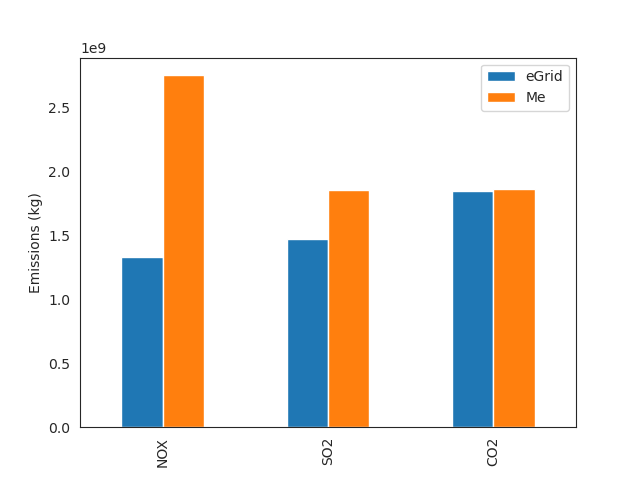

In [61]:
%matplotlib widget
fig, ax = plt.subplots()
compar.plot.bar(ax=ax)
#fig.tight_layout()
plt.ylabel('Emissions (kg)')
print(compar)

In [62]:
# CO2: -6%
# NOX: -8%
# SO2: -12%

In [63]:
gpby_me = 'NERC'; gpby_egrid='NERC'
#compar_nox = pd.DataFrame([], columns=['eGrid', 'Me'], index=us_state_abbrev.values())
#compar_so2= pd.DataFrame([], columns=['eGrid', 'Me'], index=us_state_abbrev.values())
compar_nox = pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
compar_so2= pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
compar_co2= pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
compar_gen= pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
# NOx
egrid['temp'] = egrid['PLNGENAN'] * egrid['PLNOXRTA'] * 0.45359
compar_nox['eGrid'] = egrid.groupby(gpby_egrid)['temp'].sum() 
compar_nox['Me'] = carac.groupby(gpby_me)['NOX emissions (kg)'].sum()
# SO2
egrid['temp'] = egrid['PLNGENAN'] * egrid['PLSO2RTA'] * 0.45359
compar_so2['eGrid'] = egrid.groupby(gpby_egrid)['temp'].sum() 
compar_so2['Me'] = carac.groupby(gpby_me)['SO2 emissions (kg)'].sum()
# CO2
egrid['temp'] = egrid['PLNGENAN'] * egrid['PLCO2RTA'] * 0.45359
compar_co2['eGrid'] = egrid.groupby(gpby_egrid)['temp'].sum() 
compar_co2['Me'] = carac.groupby(gpby_me)['CO2 emissions (kg)'].sum()
# Generation
compar_gen['eGrid'] = egrid.groupby(gpby_egrid)['PLNGENAN'].sum() 
compar_gen['Me'] = carac.groupby(gpby_me)['generation'].sum()

Text(0, 0.5, 'CO2 emissions (kg)')

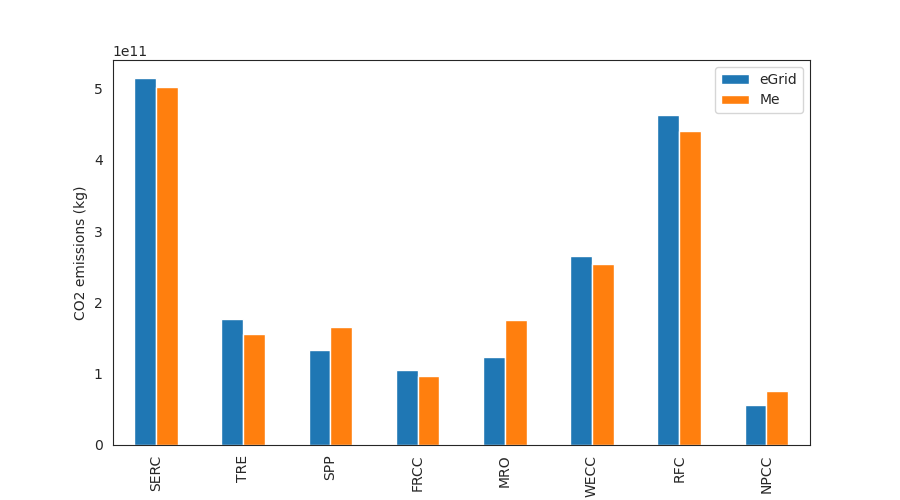

In [64]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(9,5))
compar_co2.plot.bar(ax=ax)
#fig.tight_layout()
plt.ylabel('CO2 emissions (kg)')

Text(0, 0.5, 'NOx emissions (kg)')

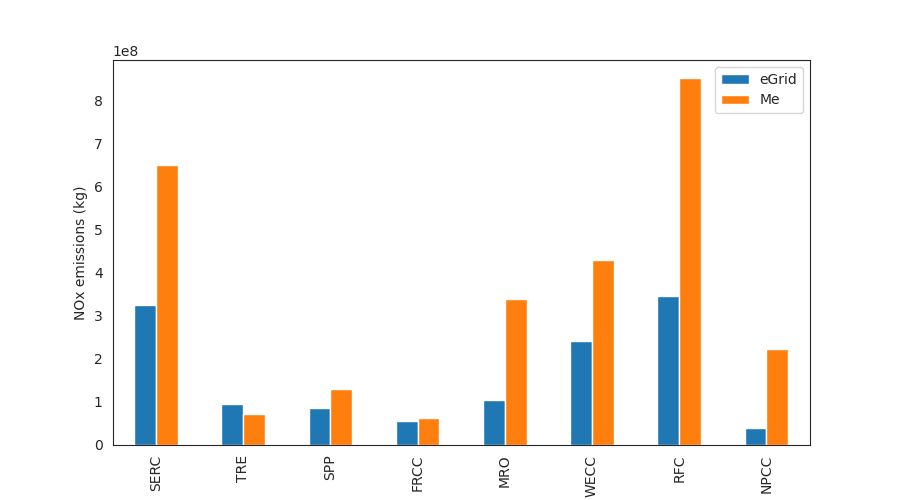

In [65]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(9,5))
compar_nox.plot.bar(ax=ax)
#fig.tight_layout()
plt.ylabel('NOx emissions (kg)')

In [66]:
carac.groupby('ORISCode')['NOX emissions (kg)'].sum()

ORISCode
2        0.000000e+00
3        2.066963e+06
4        0.000000e+00
7        7.350262e+05
8        1.337484e+06
             ...     
59300    0.000000e+00
59301    0.000000e+00
59302    0.000000e+00
59305    0.000000e+00
59306    0.000000e+00
Name: NOX emissions (kg), Length: 6019, dtype: float64

In [67]:
carac['NERC'].unique()

array(['SERC', 'TRE', 'SPP', 'FRCC', 'MRO', 'WECC', 'RFC', 'NPCC'],
      dtype=object)

In [68]:
#carac.loc[carac['StateAbb'] == 'TX','ORISCode'].unique().count()

In [69]:
import numpy as np

In [70]:
egrid_temp = egrid.copy()
egrid_temp.loc[pd.isnull(egrid_temp['PLNOXRTA']),'PLNOXRTA']=0
print(np.unique(egrid_temp.loc[egrid['PSTATABB'] == 'NM', 'ORISPL'],return_counts=True)[1].sum())
egrid_temp.loc[egrid['PSTATABB'] == 'NM', 'PLNOXRTA'].mean()

115


np.float64(1.4718869565217392)

In [71]:
np.unique(carac.loc[carac['StateAbb'] == 'NM', 'ORISCode'],return_counts=True)[1].sum()
carac.loc[carac['StateAbb'] == 'NM', 'PLNOXRTA'].mean()

np.float64(2.2396087248214287)

In [72]:
tot = 0
for ori in egrid['ORISPL'].unique():
    if ori not in carac['ORISCode'].unique():
        tot+=1
print(tot, len(egrid['ORISPL'].unique()))

3741 9709


In [73]:
tot = 0
for ori in carac['ORISCode'].unique():
    if ori not in egrid['ORISPL'].unique():
        tot += 1
print(tot, len(carac['ORISCode'].unique()))

51 6019
